In [ ]:
import os
import torch
import sys
sys.path.append("/".join(os.getcwd().split("/")[:-1]))
from common import *

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_name = 'opt-6.7b' #'llama3-8b'
checkpoint_path = '../models/opt-6.7b' #'../models/llama3-8b'

# Step1：Load Model and Data

In [2]:
from transformers import OPTForCausalLM,AutoModelForCausalLM
from transformers import AutoTokenizer

model = AutoModelForCausalLM.from_pretrained(checkpoint_path, device_map=device, torch_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path, device_map=device)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
from datasets import load_dataset
import os
import subprocess

dataset = load_dataset("allenai/c4",data_files={"train": "en/c4-train.00000-of-01024.json.gz"},
                        split="train")

print("Dataset Info:")
print(dataset)

Dataset Info:
Dataset({
    features: ['text', 'timestamp', 'url'],
    num_rows: 356317
})


# Step2：Collect Activation

In [ ]:
import torch
import re




# Select 50 sentences for observation 
data=dataset['text'][:50]    

activations = []
for i in range(len(data)):
    prompt = data[i]
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    # Avoid too long sentences
    for key in inputs.keys():
        inputs[key] = inputs[key][:, :250]
   
    activation_dict = {}
    
    hooks = register_act_hooks(model, activation_dict)

    with torch.no_grad():
        outputs = model(**inputs)
        
    activations.append(activation_dict)

    remove_hooks(hooks)
    
    del outputs
    del inputs
    del activation_dict


In [ ]:
Layer_num = 25
layer_act=[]
sentence_lenth=[]
str_act = get_layer_name(model_name, Layer_num)
for i in range(len(activations)):
    tensor = activations[i][str_act].cpu()
    if "llama" in model_name:
        tensor = tensor.squeeze(0)
    layer_act.append(tensor)
    m=tensor.size(0)
    sentence_lenth.append(m)
A_tensor = torch.cat(layer_act, dim=0)

# Step3: Calculate the distance between core neurons of different tokens

In [ ]:
neuron_num = MODEL_INFO[model_name]['num_neurons']
    
token_sparisity = 0.2
remained_neurons = int(neuron_num * token_sparisity)
act_all=(A_tensor).cpu()
sorted_values, sorted_indices = torch.sort(act_all, dim=1, descending=True)
top50_indices = sorted_indices[:, :remained_neurons]
top50_indices.size()

torch.Size([9524, 180])

In [7]:
from collections import Counter
def custom_distance(x, y):
    return (remained_neurons-sum((Counter(x) & Counter(y)).values()))

data = top50_indices.clone().numpy()
dis=torch.zeros((data.shape[0],data.shape[0]))
for i in range(data.shape[0]):
    for j in range(i + 1, data.shape[0]):  
        distance = custom_distance(data[i], data[j])
        dis[i, j] = distance
        dis[j, i] = distance 
    dis[i, i] = 0 

# Step4: Observe the Clustering of Core Neurons of Tokens in the Same Sentence

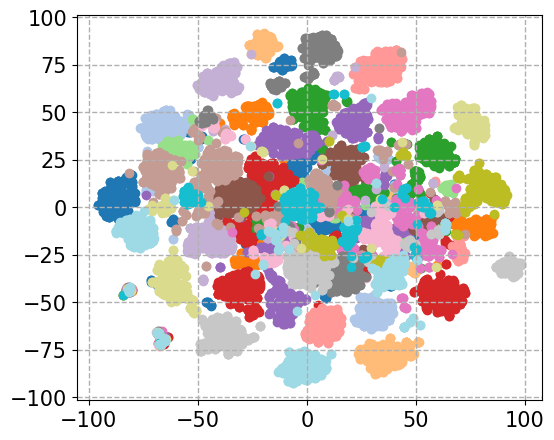

In [8]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

sentence=[]
num=0
for i in range(len(sentence_lenth)):
    lenth=sentence_lenth[i]
    list_now=list(range(num, num+lenth))
    sentence.append(list_now)
    num=num+lenth



A = dis.cpu().numpy()
np.fill_diagonal(A, 0)

tsne = TSNE(metric="precomputed", n_components=2, random_state=42, init='random')
embedded = tsne.fit_transform(A)


plt.figure(figsize=(6, 5))
colors = plt.cm.get_cmap('tab20', len(sentence_lenth))  # Choose a colormap with enough distinct colors

for i in range(len(sentence_lenth)):
    cluster_points = embedded[sentence[i]]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors(i), label=f"Cluster {i}")

# plt.legend()
# plt.xlabel("Dimension 1")
# plt.ylabel("Dimension 2")
# plt.title("2D visualization of clusters")
font_properties = FontProperties(family='serif', style='italic', size=15)
# plt.legend(loc='lower right',prop=font_properties, framealpha=0.5)
plt.tick_params(labelsize=15)
plt.rcParams.update({'font.size':15}) 
plt.grid(True, linestyle='--', linewidth=1)
plt.savefig('sentence_cluster.pdf',bbox_inches='tight')
plt.show()